## Introduction
Help the supermarket chain Good Seed to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. Use computer vision to determine individuals age. 
## Initialization

In [ ]:
pip install seaborn --upgrade

     |████████████████████████████████| 294 kB 14.5 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
display(labels.isna().sum())
print('amount duplicated:',labels.duplicated().sum())

file_name    0
real_age     0
dtype: int64

amount duplicated: 0


## EDA

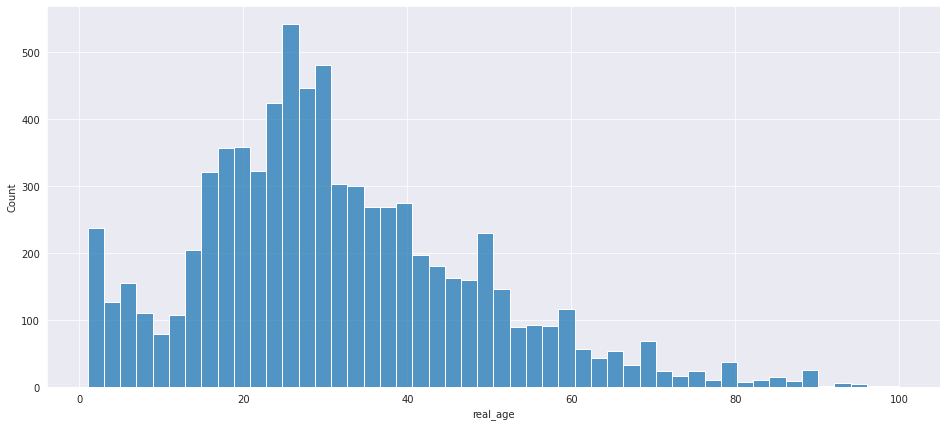

In [5]:
# Histogram of real_age column for understand age distribution in the df.
sns.set_style('darkgrid')
plt.figure(figsize=(16,7))
sns.histplot(labels['real_age'], bins = 50)
plt.show()

Found 7591 validated image filenames.


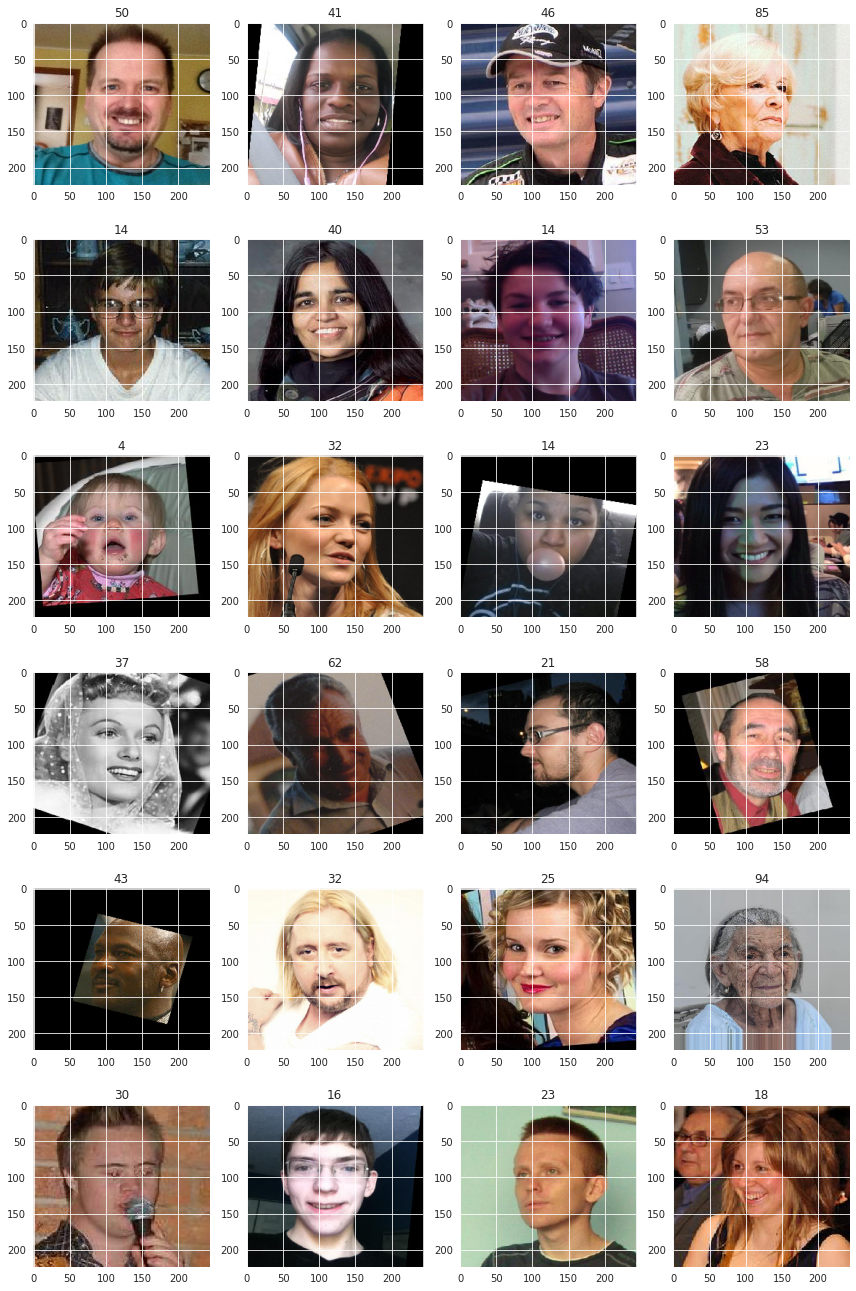

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

data_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224,244),
    batch_size = 32,
    class_mode = 'raw',
    seed = 12345)

def show_images(batch, predictions=None):
    fig = plt.figure(figsize=(12,24))
    
    for i in range(24):
        fig.add_subplot(8,4, i+1)
        plt.imshow(batch[0][i])
        title = batch[1][i]
        if predictions is not None:
            title = f'gt: {title}, prediction: {round(predictions[i])}'
        plt.title(title)
        
    fig.tight_layout()

show_images(next(data_flow))

### Findings

<div class="alert alert-info">
  Its a regression task.  We don't need negative values to be computed to use ReLu activation to transform those values to zero. Final layer is needed with just one output as one value is target.  The loss function we use is 'MSE' and the metric used is 'MAE' and to be less than 8.
</div> 

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=20,
        zoom_range=0.2,
        rescale=1/255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  # Increased the batch size for better generalization
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

In [9]:
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  # Consistency in batch size with training data
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

In [10]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',  # Kept the weights as 'imagenet' for transfer learning benefits
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Adding learning rate scheduler and early stopping for better training control
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [lr_scheduler, early_stopping]

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              callbacks=callbacks)  # Added the callbacks here

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# my script that would run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')




if __name__ == '__main__':
    path = '/datasets/faces/' 

    train_data = load_train(path)
    test_data = load_test(path)

    model = create_model(input_shape=(150, 150, 3)) 

    model = train_model(model, train_data, test_data, batch_size=32, epochs=20)


### Output

Place the output from the GPU platform as an Markdown cell here.

#Train for 356 steps, validate for 119 steps
Epoch 1/29
2021-07-22 13:50:45.795361: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-22 13:50:46.078498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 45s - loss: 185.5438 - mae: 10.1316 - val_loss: 409.6900 - val_mae: 15.
Epoch 2/29
356/356 - 37s - loss: 92.4636 - mae: 7.2383 - val_loss: 163.8210 - val_mae: 9.8725
Epoch 3/29
356/356 - 38s - loss: 58.3541 - mae: 5.8983 - val_loss: 114.8840 - val_mae: 8.1869
Epoch 4/29
356/356 - 38s - loss: 35.4366 - mae: 4.6185 - val_loss: 80.9308 - val_mae: 6.7085
Epoch 5/29
356/356 - 37s - loss: 24.7770 - mae: 3.7921 - val_loss: 79.9232 - val_mae: 6.8614
Epoch 6/29
356/356 - 37s - loss: 17.7439 - mae: 3.2320 - val_loss: 98.5480 - val_mae: 7.2196
Epoch 7/29
356/356 - 37s - loss: 14.5933 - mae: 2.9475 - val_loss: 70.7268 - val_mae: 6.3024
Epoch 8/29
356/356 - 37s - loss: 14.8196 - mae: 2.9326 - val_loss: 71.9305 - val_mae: 6.3556
Epoch 9/29
356/356 - 38s - loss: 14.9091 - mae: 2.9338 - val_loss: 78.4009 - val_mae: 6.8505
Epoch 10/29
356/356 - 38s - loss: 13.1682 - mae: 2.7679 - val_loss: 72.5286 - val_mae: 6.3034
Epoch 11/29
356/356 - 38s - loss: 14.2221 - mae: 2.8717 - val_loss: 80.2753 - val_mae: 6.7456
Epoch 12/29
356/356 - 37s - loss: 14.6156 - mae: 2.8886 - val_loss: 78.9146 - val_mae: 6.5796
Epoch 13/29
356/356 - 38s - loss: 12.9957 - mae: 2.7320 - val_loss: 72.9162 - val_mae: 6.4381
Epoch 14/29
356/356 - 37s - loss: 10.5154 - mae: 2.4850 - val_loss: 72.7064 - val_mae: 6.3392
Epoch 15/29
356/356 - 37s - loss: 8.9872 - mae: 2.2824 - val_loss: 69.2501 - val_mae: 6.0371
Epoch 16/29
356/356 - 37s - loss: 7.7286 - mae: 2.0973 - val_loss: 77.2039 - val_mae: 6.7151
Epoch 17/29
356/356 - 37s - loss: 8.8071 - mae: 2.2553 - val_loss: 121.5123 - val_mae: 8.0337
Epoch 18/29
356/356 - 38s - loss: 23.3677 - mae: 3.6460 - val_loss: 115.0686 - val_mae: 8.3702
Epoch 19/29
356/356 - 38s - loss: 23.0183 - mae: 3.6145 - val_loss: 81.9440 - val_mae: 6.9290
Epoch 20/29
356/356 - 38s - loss: 11.9603 - mae: 2.5756 - val_loss: 73.5473 - val_mae: 6.2886
Epoch 21/29
356/356 - 37s - loss: 5.7950 - mae: 1.7971 - val_loss: 67.1093 - val_mae: 6.0874
Epoch 22/29
356/356 - 37s - loss: 3.2634 - mae: 1.3526 - val_loss: 68.1328 - val_mae: 6.1040
Epoch 23/29
356/356 - 38s - loss: 2.4278 - mae: 1.1653 - val_loss: 66.3813 - val_mae: 6.0967
Epoch 24/29
356/356 - 38s - loss: 2.6048 - mae: 1.2062 - val_loss: 68.4044 - val_mae: 6.2353
Epoch 25/29
356/356 - 37s - loss: 3.3497 - mae: 1.3657 - val_loss: 68.4114 - val_mae: 6.2043
Epoch 26/29
356/356 - 38s - loss: 5.0504 - mae: 1.6865 - val_loss: 65.6572 - val_mae: 6.0358
Epoch 27/29
356/356 - 38s - loss: 7.0184 - mae: 2.0083 - val_loss: 70.4858 - val_mae: 6.2259
Epoch 28/29
356/356 - 37s - loss: 8.7682 - mae: 2.2477 - val_loss: 78.1103 - val_mae: 6.5730
Epoch 29/29
356/356 - 38s - loss: 9.7636 - mae: 2.3855 - val_loss: 68.7942 - val_mae: 6.1227

## Conclusions

<div class="alert alert-info">
  In this model, a neural network was trained to recognize from photos of people; a person's age.  A regression task with details of the model including the backbone of a ResNet50, specified activation as 'relu' to transform negative values into 0 and added a final layer with one neuron to return a single output. Loss function choosen was 'mse', and metric was 'mae'. Batch size at 16 and learning rate of; r=0.00025.

Yes this technology can be used for many details, such as banks and checkouts reading peoples' faces.  Airports checking customers in and many more privacy invasive processes. 
</div> 